# Reading the SIMBA buoy supplementary data

The SIMBA instruments contain compass data to enable tracking of ice floe rotation. We will need to make an estimate of the accuracy of this information. They also contain additional surface meteorology measurements (pressure, temperature) that we can use if needed. 

To start with, here is the code snippet I used to extract the data from the .tab files.

In [3]:
import sys
sys.path.append('../scripts')
import proplot as pplt
import pandas as pd
import pyproj
import numpy as np
from helpers import *
from sklearn.neighbors import NearestNeighbors


def print(*val):
    display(*val)

%run ../scripts/process_simba.py

The additional data can tell you something about the data quality, and the eventual fate of the sensor. For example, the tilt can show you if the buoy is starting to experience ice breakup, or if the instrument tips over.

## Setup

In [4]:
metadata = simba_metadata().merge(buoy_metadata(), left_index=True, right_index=True, how="left")
metadata.index.names = ['Sensor ID']
metadata = metadata[metadata["hasCompass"]]

## Nearest neighbor for starting pos

In [31]:
projIn = 'epsg:4326' # WGS 84 Ellipsoid
projOut = 'epsg:3413' # NSIDC Polar Stereographic
transform_to_xy = pyproj.Transformer.from_crs(projIn, projOut, always_xy=True)
transform_to_ll = pyproj.Transformer.from_crs(projOut, projIn, always_xy=True)

def buoyPos(buoy, ind=0):
    return np.array(buoy_data(buoy)[['latitude', "longitude"]].head(1))[ind]

valid_buoys = metadata[metadata["hasCompass"]].index

inits = np.array([buoyPos(buoy) for buoy in valid_buoys])

lats = inits[:, 0]
lons = inits[:, 1]

x, y = transform_to_xy.transform(lons, lats)
xy = np.dstack([x,y])[0]

nn = NearestNeighbors(n_neighbors=2).fit(xy)
dist, clusters = nn.kneighbors(xy)

pairs = np.array(valid_buoys)[clusters]
print(pd.DataFrame(zip(pairs[:,0], pairs[:, 1], dist[:, 1]), columns=["Buoy1", "Buoy2", "Dist"]))

,Buoy1,Buoy2,Dist
0,2019T56,2019T62,31198.076341
1,2019T58,2019T70,2295.304675
2,2019T62,2019T66,368.273840
3,2019T63,2019T65,728.050580
4,2019T64,2019T67,13298.588172
5,2019T65,2019T63,728.050580
6,2019T66,2019T62,368.273840
7,2019T67,2019T64,13298.588172
8,2019T68,2019T67,17733.995798
9,2019T69,2019T63,5120.691325


## Buoy Velocities

In [6]:
b1 = "2019T62"
b2 = "2019T66"

In [7]:
def rotational_velocity(data):
    shifts = data - data.shift()
    shifts[shifts > 180] = 360 - shifts[shifts > 180]
    shifts[shifts < -180] = 360 + shifts[shifts < -180]
    dt = data.index.diff()/pd.Timedelta(hours=1)
    return shifts.div(np.array(dt), axis=0).dropna()

In [8]:
geodesic = pyproj.Geod(ellps="WGS84")
a=89.9999999
geodesic.inv(0,a,45,a)[0]

67.5

In [29]:
buoy_metadata(b2)

Deployment Leg                                                                1
DN Station ID                                                                LM
IMEI                                                            300234068706330
Deployment Date                                                      2019-10-29
Deployment Datetime                                         2019-10-29 01:45:00
First Data Datetime                                         2019-10-29 02:11:33
Last Data Datetime                                          2020-08-14 09:00:13
Active                                                                        0
Sampling Frequency (hh:mm)                                                00:30
Re-deployed As                                                              NaN
Formerly Deployed As                                                        NaN
Buoy Type                                                            Thermistor
Manufacturer                            

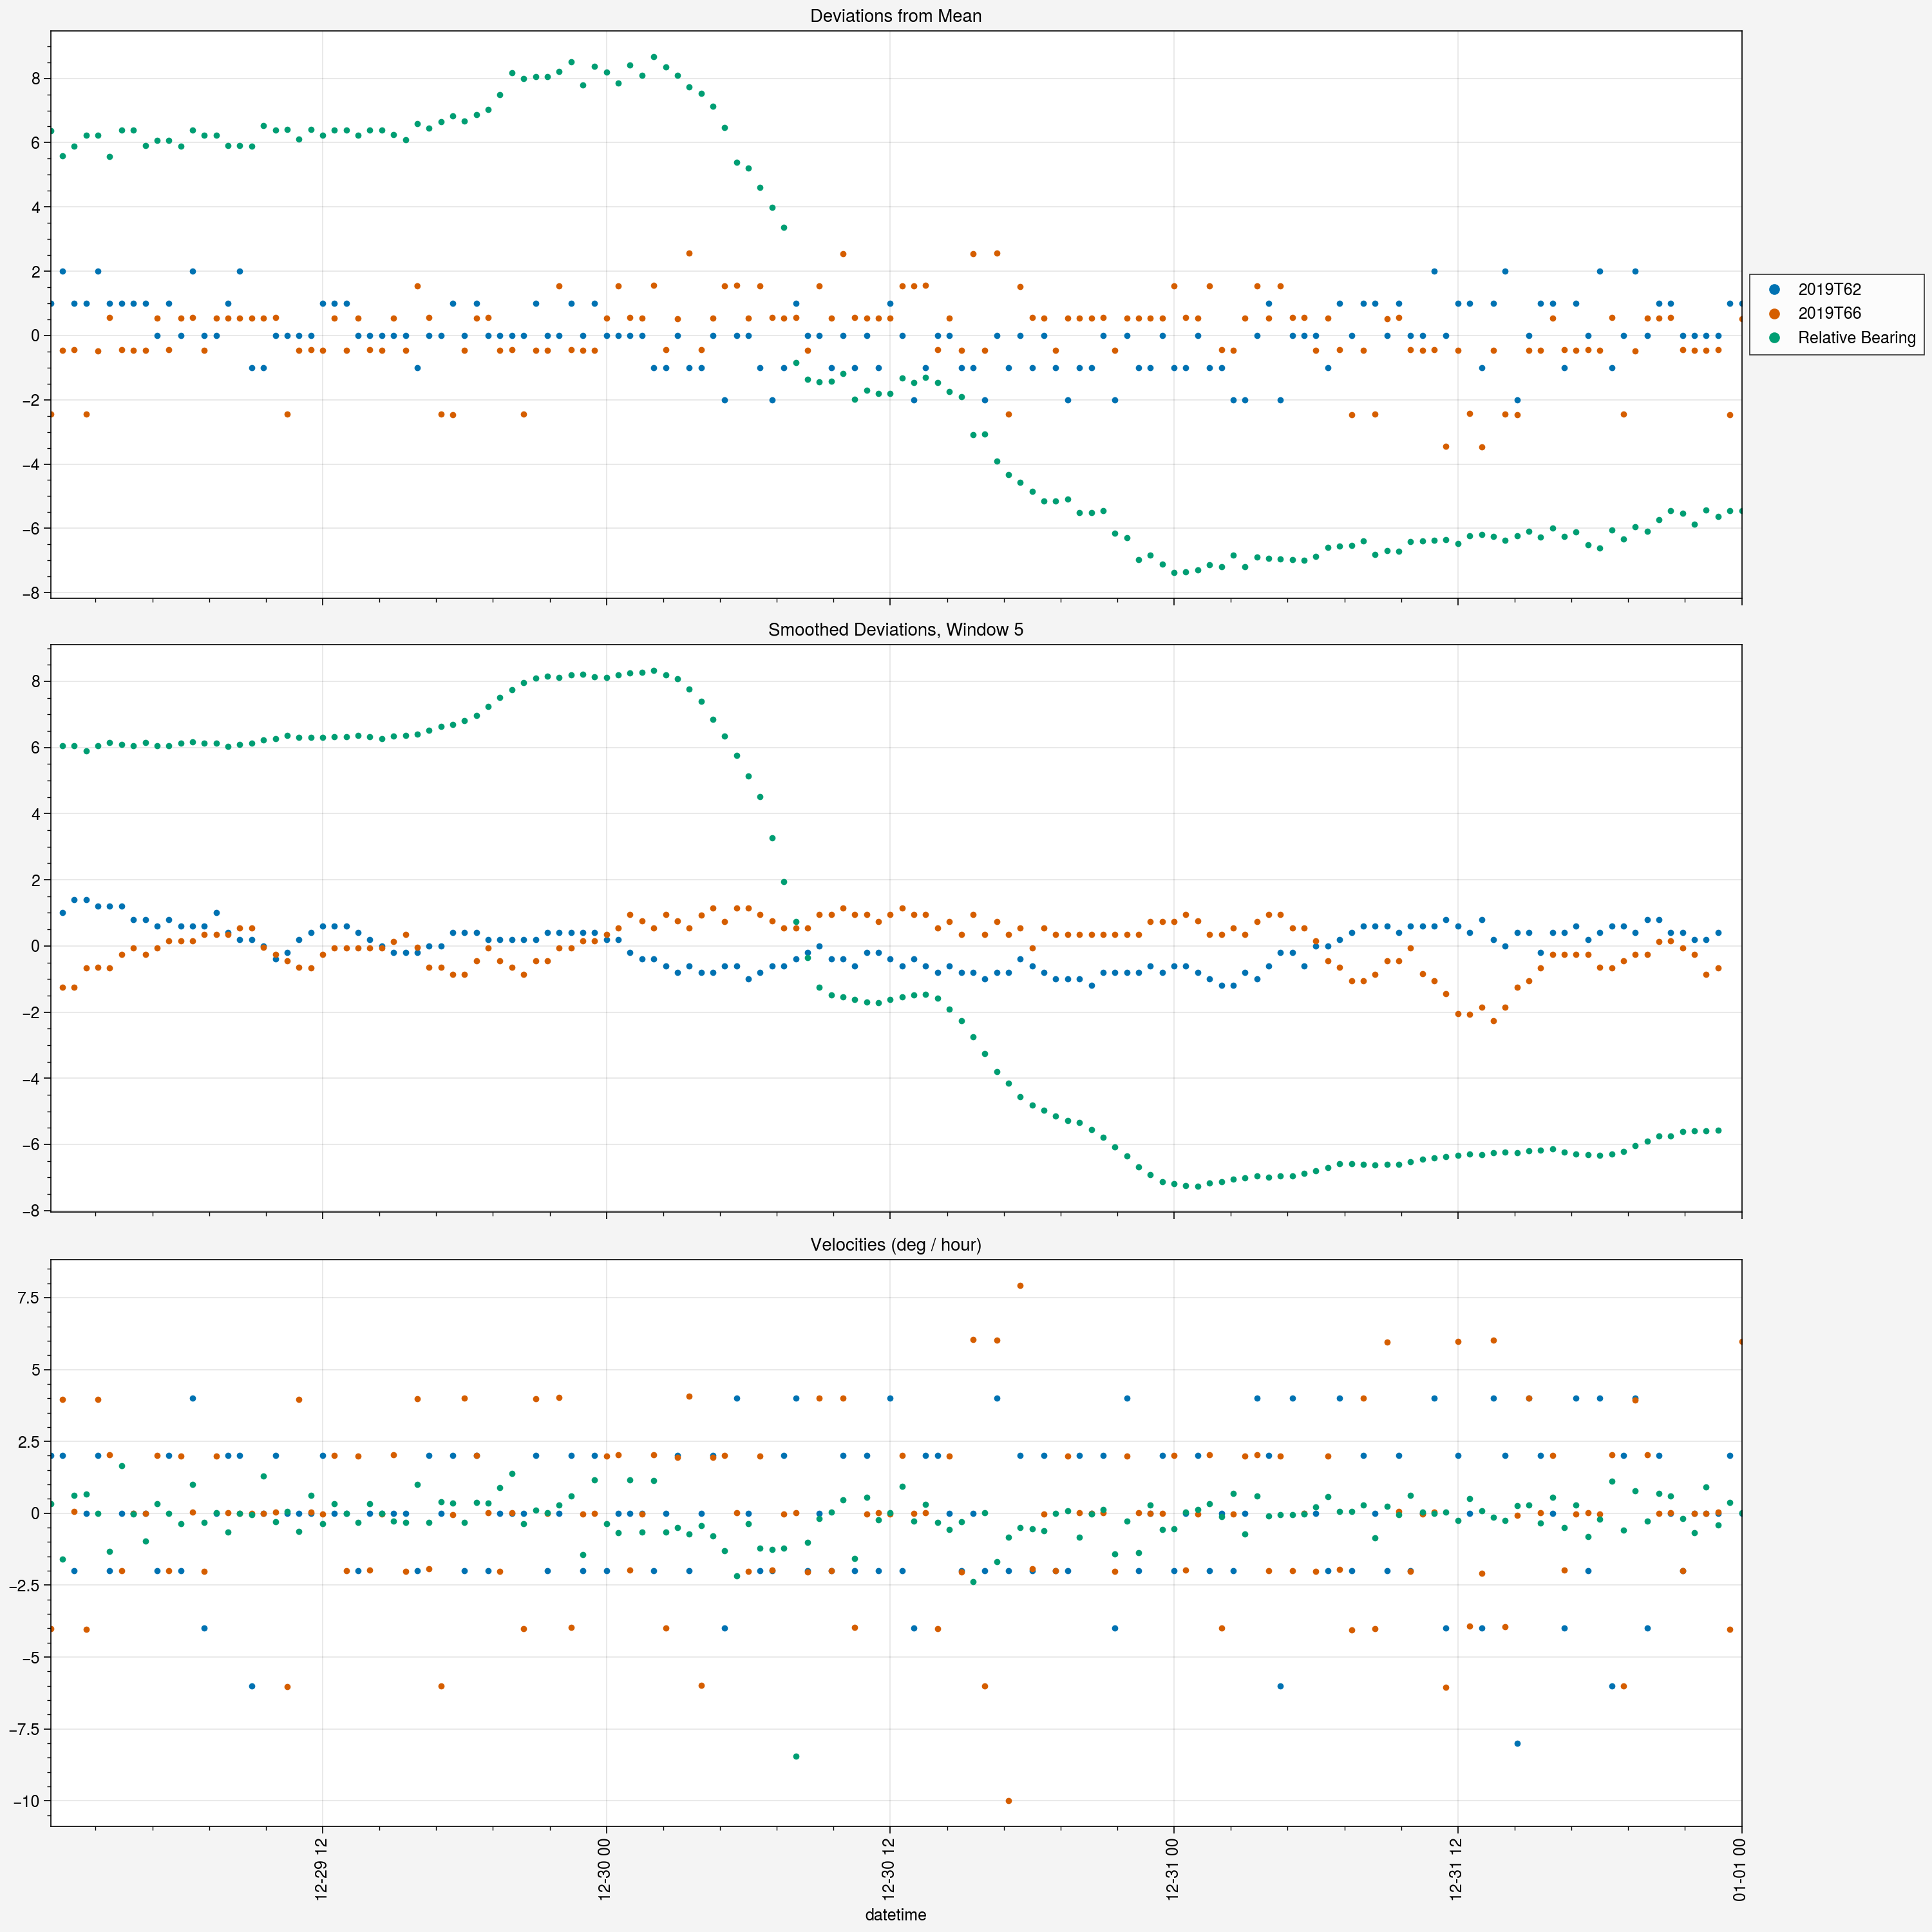

In [27]:
a = simba_data(b1)["Compass bearing [deg]"].rename("a")
b = simba_data(b2)["Compass bearing [deg]"].rename("b")
a.index = pd.to_datetime(a.index)
b.index = pd.to_datetime(b.index)

date_slice = slice("2019-12-29 00:00:00", "2020-01-01 00:00:00")

# a = a.resample("1d", offset="11h").asfreq().dropna()
# b = b.resample("1d", offset="11h").asfreq().dropna()

geodesic = pyproj.Geod(ellps="WGS84")
a_path = buoy_data(b1).set_index("datetime")[date_slice]
b_path = buoy_data(b2).set_index("datetime")[date_slice]

paths = a_path.merge(b_path, left_index=True, right_index=True, suffixes=['_a', '_b'])
paths = paths[date_slice]
paths['fwd_angle'] = geodesic.inv(paths["longitude_a"], paths["latitude_a"], paths["longitude_b"], paths["latitude_b"])[0]

combined = pd.concat([a, b, paths['fwd_angle']], axis=1).dropna()
combined.columns = b1, b2, "Relative Bearing"
combined = combined[date_slice]

deviations = combined - combined.mean(axis=0)
window = 5
smoothed_deviations = deviations.rolling(window, center=True).mean()
velocities = rotational_velocity(deviations)
smoothed_velocities = rotational_velocity(smoothed_deviations)

corr_window = 10
rolling_corr = velocities[b1].rolling(corr_window).corr(velocities[b2])

num_graphs = 3
fig, ax = pplt.subplots(nrows=num_graphs, figsize=(15,5*num_graphs))

cur_graph = 0

ax[cur_graph].plot(deviations, m=".", ms=5, lw=0)
ax[cur_graph].format(title="Deviations from Mean")
ax[cur_graph].legend(ncols=1, ms=10, loc="r")
cur_graph += 1

#ax[cur_graph].plot(rolling_corr)
#ax[cur_graph].format(title=f"Correlations between Deviations")
#cur_graph += 1

ax[cur_graph].plot(smoothed_deviations, m=".", ms=5, lw=0)
ax[cur_graph].format(title=f"Smoothed Deviations, Window {window}")
cur_graph += 1

ax[cur_graph].plot(velocities, m=".", ms=5, lw=0)
ax[cur_graph].format(title="Velocities (deg / hour)")
cur_graph += 1


,Compass bearing [deg]
count,12126.000000
mean,0.000829
std,2.582489
min,-10.023680
25%,-1.993780
50%,0.000090
75%,1.992625
max,10.078260


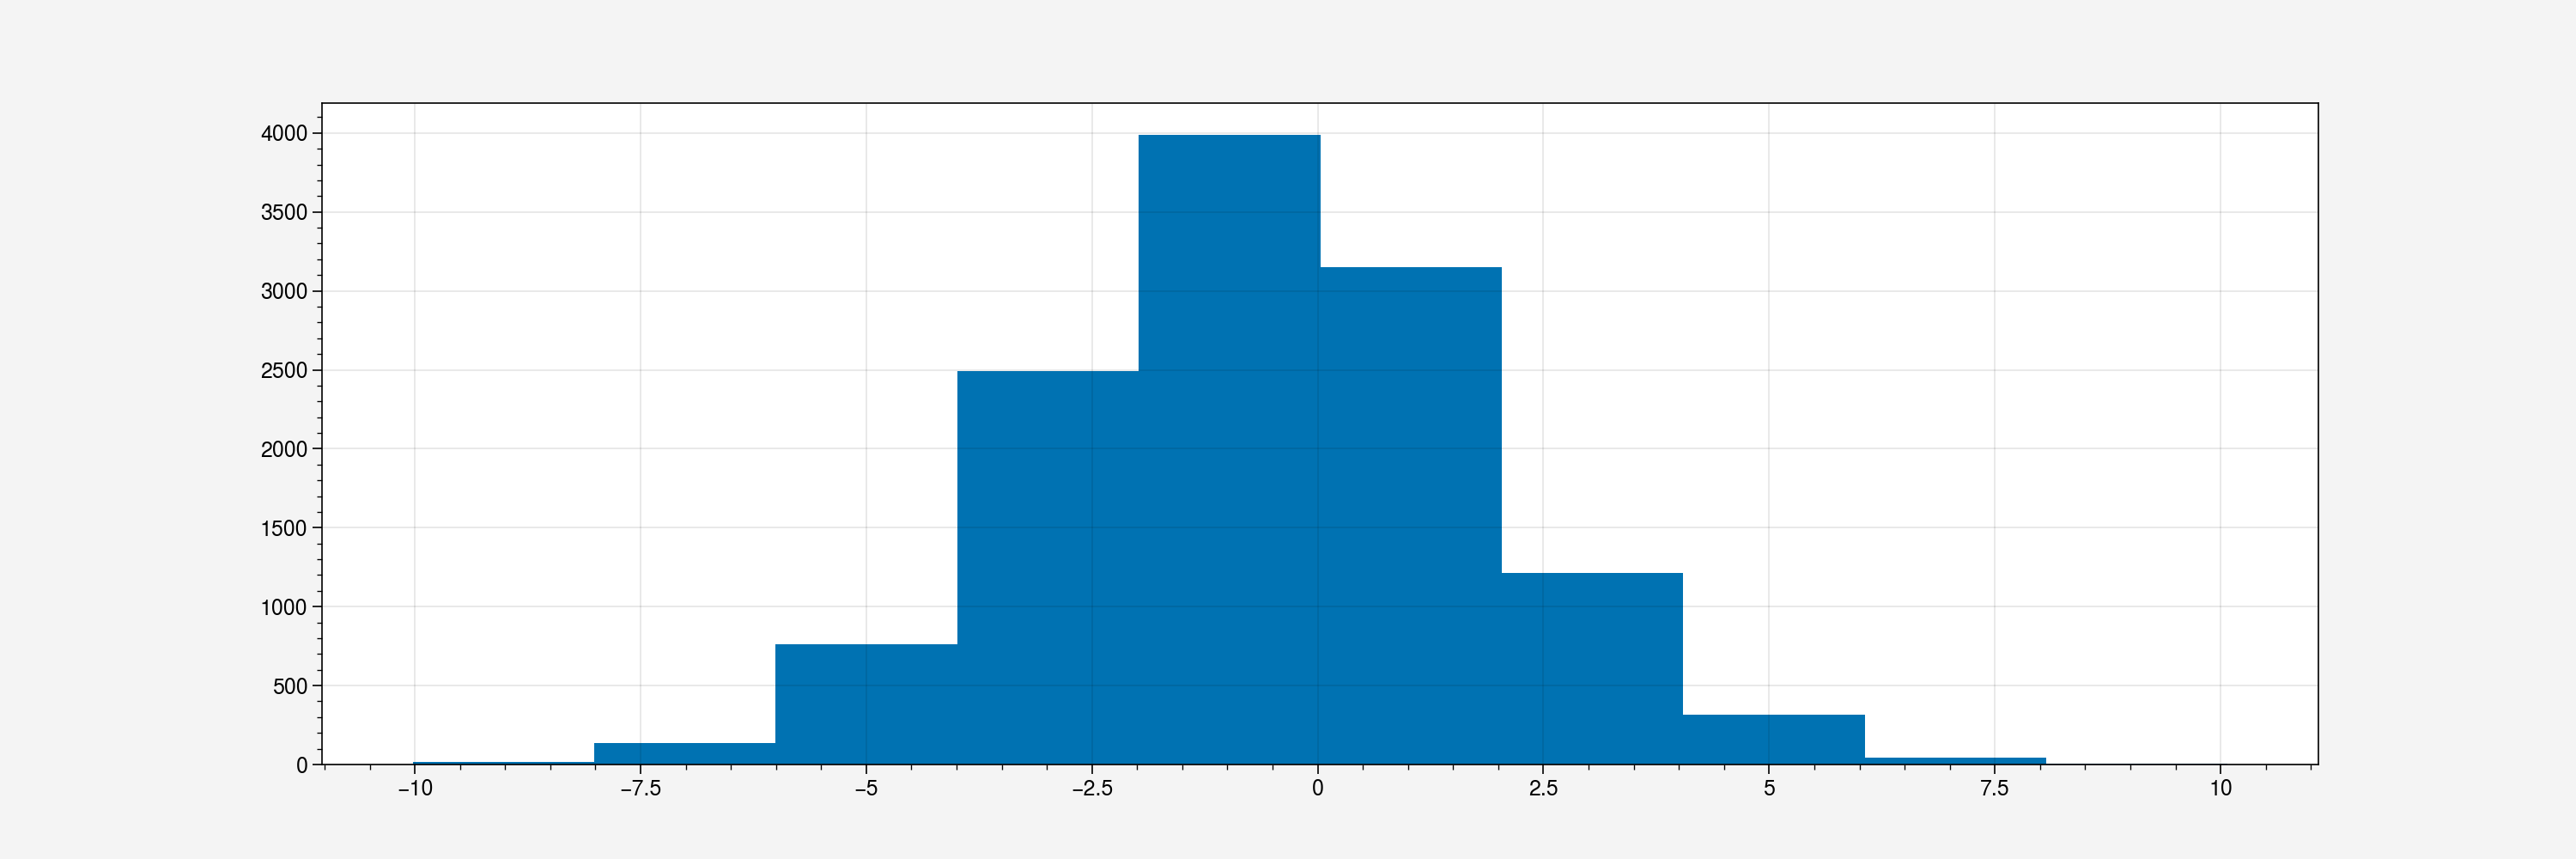

In [10]:
a = simba_data("2019T65")["Compass bearing [deg]"]
a.index = pd.to_datetime(a.index)
# a = a.resample("1h", offset="11h").asfreq().dropna()

a = a[:"2020-06-15"]
velocities = rotational_velocity(a)
velocities.hist(figsize=(15,5), bins=10)
pd.DataFrame(velocities.describe())


/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


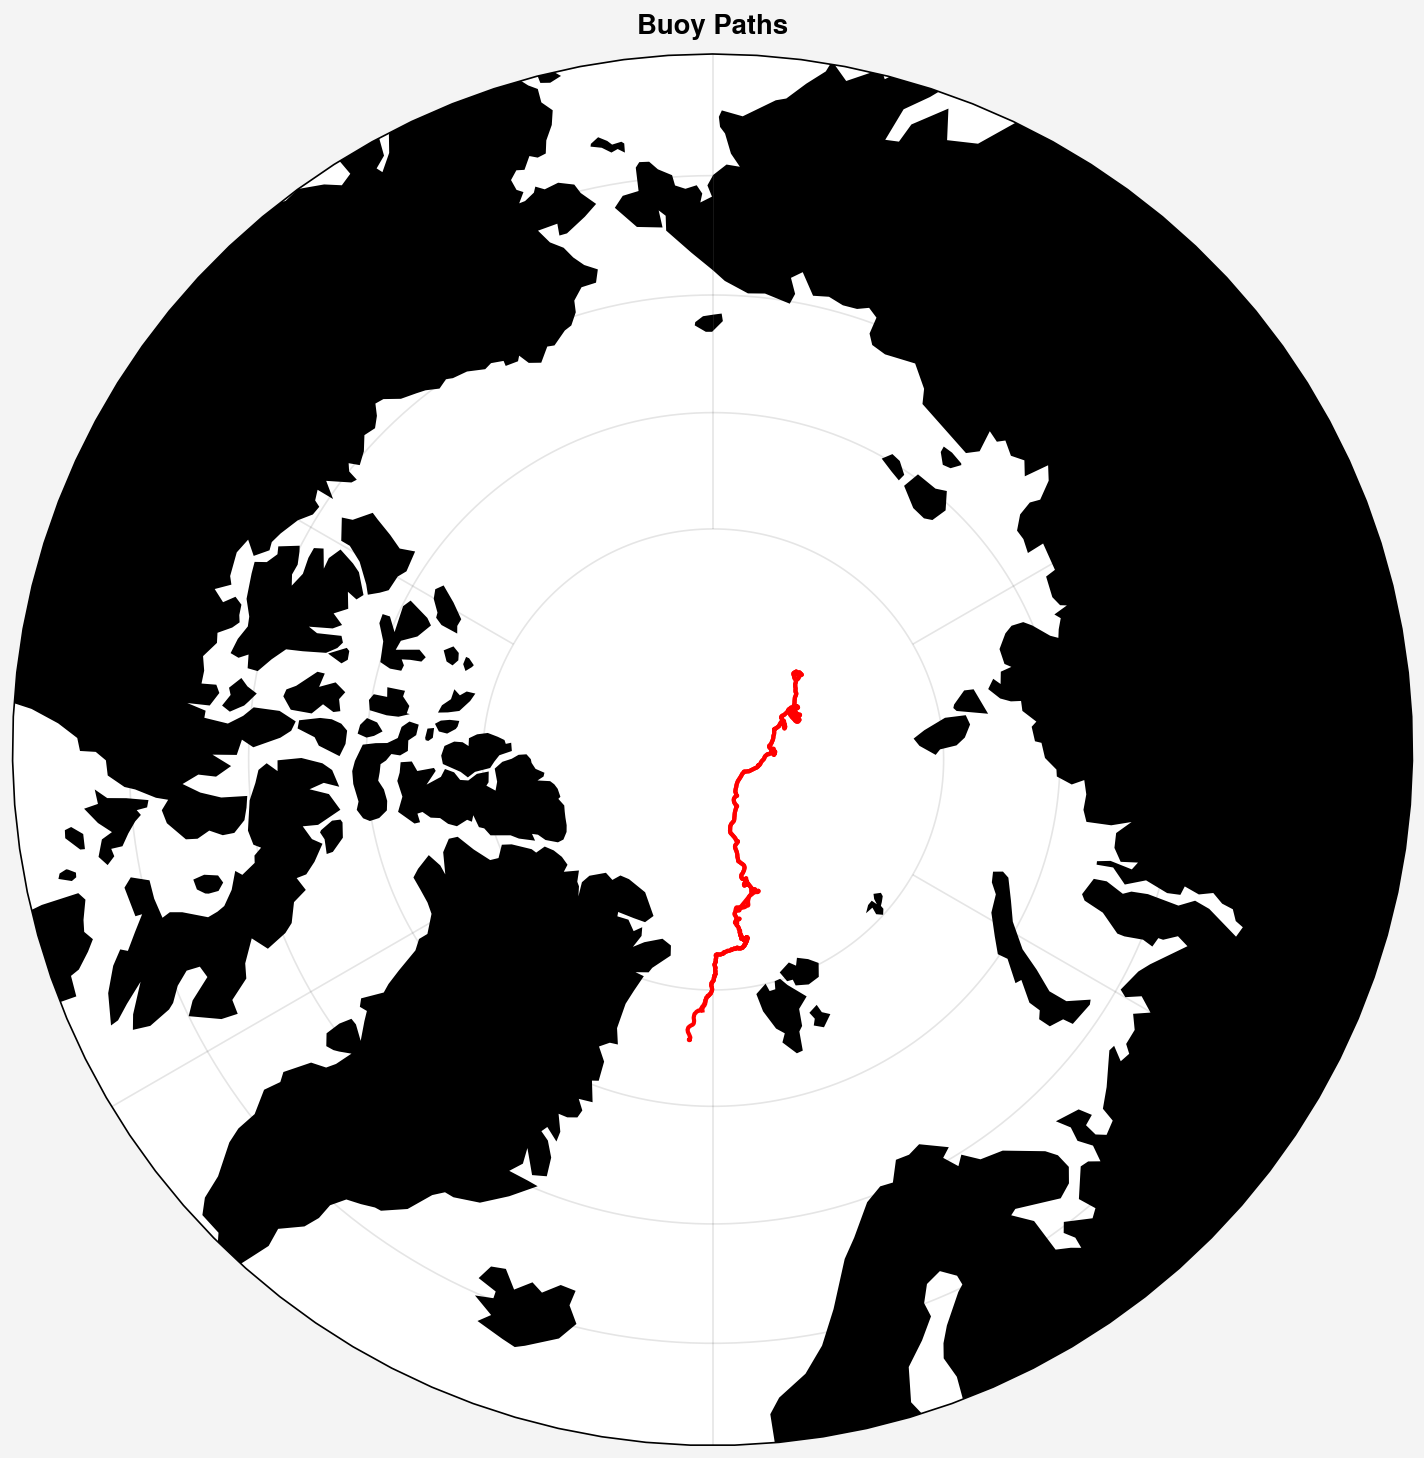

In [11]:
plot_path(["2019T63", "2019T65"])

## Does distance between buoys change over time?

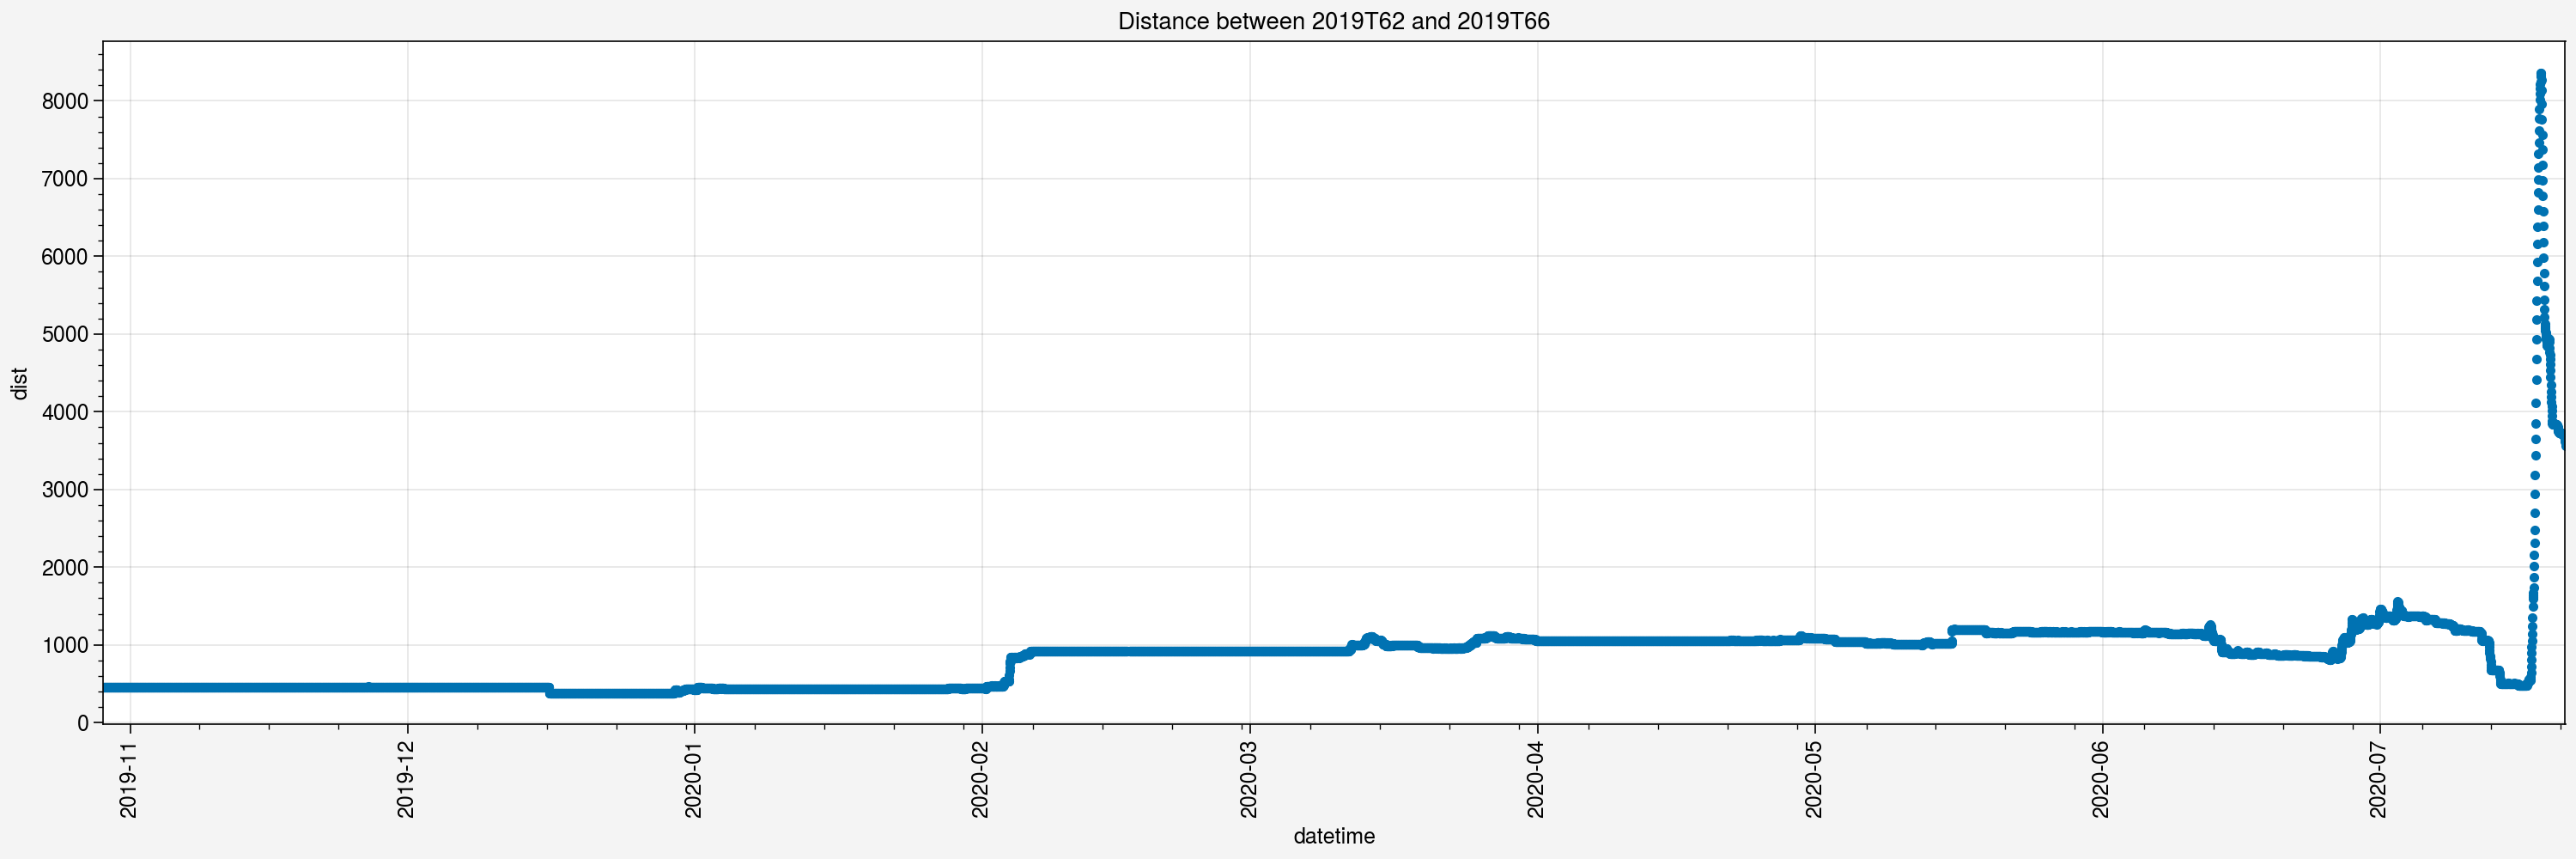

In [12]:
a = buoy_data(b1).set_index("datetime")[["x_stere", "y_stere"]]
b = buoy_data(b2).set_index("datetime")[["x_stere", "y_stere"]]

merged = a.merge(b, left_index=True, right_index=True, suffixes=["1","2"])
merged["dist"] = np.sqrt((merged["x_stere1"] - merged["x_stere2"])**2 + (merged["y_stere1"] - merged["y_stere2"])**2)
distances = merged["dist"]

fig, ax = pplt.subplots(figsize=(15,5))
distances = distances[:"2020-07-20"]
ax.plot(distances, m='.', lw=0)
ax.format(title=f"Distance between {b1} and {b2}")